In [40]:
import numpy as np
import pandas as pd
from numpy.random import randn, normal, uniform
from statistics import mean, stdev
import h2o
import os
import time
import math
import matplotlib.pyplot as plt

from evaluation.helpers import mask, continuous2ordinal
from em.low_rank_expectation_maximization import LowRankExpectationMaximization
from glrm.loss import OrdinalLoss
from glrm.reg import QuadraticReg
from glrm.glrm import GLRM
from glrm.convergence import Convergence
from glrm.util import pplot

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [3]:
import pyglrm

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [4]:
# Init h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 2 hours 38 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_ongrayyi_om4s5l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.825 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [4]:
# Function for calculating error

class OrdErr():
    def __call__(self, A, A_hat, indices=None, all_thresh=False): 
        A_diff = np.abs(A - A_hat)
        if indices is not None:
            A_diff_temp = []
            for i, j in indices:
                A_diff_temp.append(A_diff[i, j])
            A_diff = np.array(A_diff_temp)
        if all_thresh is True:
            return np.sum(np.vectorize(cumu_sum)(A_diff)) / A_diff.size
        else:
            return np.sum(A_diff) / A_diff.size

def cumu_sum(x):
    return sum(i+1 for i in range(int(x)))

In [13]:
# Functions for generating ordinal data

def generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=1, orig = False):
    np.random.seed(seed)  
    A = randn(m,k).dot(randn(k,n))
    
    if noise == 'gaussian':
        noise_arr = np.zeros((m,n))
        for j in range(n):
            sigma_j = np.std(A[:, j])
            noise_arr[:, j] = normal(scale=sigma_j, size=m)
        A += noise_arr

    for ord_index in range(n):
        q = np.quantile(A[:,ord_index], (0.02,0.98))
        Z_max = A[:,ord_index].max()
        Z_min = A[:,ord_index].min()
        step = (q[1]-q[0])/ord_num
        cutoff = [Z_min]
        cutoff += [(q[0] + i*step) for i in range(1, ord_num)]
        cutoff.append(Z_max + 0.1)
        A[:,ord_index] = continuous2ordinal(A[:,ord_index], k=ord_num, cutoff=cutoff)
    
    A_orig = A.copy()
    
    if noise == 'rndselect':
        nums = np.zeros(5)
        ords = [1, 2, 3, 4, 5]
        for i in range(m):
            for j in range(n):
                index = int(A[i, j] - 1)
                nums[index] += 1
        nums = np.cumsum(nums)
        
        sigma_A = np.std(A)
        for i in range(m):
            for j in range(n):
                if uniform() < noise_lvl:
                    rand = np.random.randint(1, nums[-1]+1)
                    for k, num in enumerate(nums):
                        new = 1
                        if rand <= num:
                            new = ords[k]
                        #A[i, j] == np.random.randint(1, ord_num+1)
                        A[i, j] = new
    if orig is False:
        return A
    else:
        return A, A_orig

In [6]:
def to_ord(X):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            x = X[i, j]
            if x > 5:
                X[i, j] = 5
            elif x < 1:
                X[i, j] = 1
            else:
                X[i, j] = int(round(X[i, j])) 

In [7]:
# Function for doing experiments

def imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss='absolute', reg=0, mode='w'):
    # Compute average of errors for each rank
    
    #Log
    file_path = 'imputation_exp_outputs/'+ exp_name + '.txt'
    if os.path.exists(file_path):
          os.remove(file_path)
    
    k_list = []
    mean_errs = []
    std_dev_errs = []
    mean_times = []
    std_dev_times = []
    pred_err = OrdErr()

    for k_model in k_exp_list:
        with open(file_path, 'a+') as file:
            file.write('----- RANK {} -----\n'.format(k_model))
        k_fixed_times = []
        k_fixed_errs = []
        for i in range(iterations):

            # Generate data
            A_masked, mask_indices, _ = mask(A, ratio, seed=i)
            if model_type == 'glrm_h2o':
                A_masked = pd.DataFrame(A_masked)
                for index in mask_indices:
                    A_masked.loc[index[0], index[1]] = 'missing'

            # Impute data
            start_time = time.time()
            if model_type == 'lrgc':
                model = LowRankExpectationMaximization()
                A_imp, _, _ = model.impute_missing(A_masked, k_model, verbose=True)
            elif model_type == 'glrm':
                if loss == 'ordhinge':
                    mask_indices_split = [[tuple(index) for index in mask_indices]]
                    glrm_loss = [OrdinalLoss]
                    regX, regY = QuadraticReg(reg), QuadraticReg(reg)
                    converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
                    model = GLRM([A], glrm_loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
                    model.fit();
                    A_imp = model.predict()
            elif model_type == 'glrm_h2o':
                train = h2o.H2OFrame(A_masked, na_strings=['missing'], column_types = ['enum']*A.shape[1])
                glrm_model = H2OGeneralizedLowRankEstimator(k=k_model,
                            loss=loss,
                            gamma_x=reg,
                            gamma_y=reg,
                            max_iterations=700,
                            recover_svd=True,
                            init="SVD")
                glrm_model.train(training_frame=train)
                A_imp = glrm_model.predict(train)
                A_imp = A_imp.as_data_frame().to_numpy()
            elif model_type == 'pyglrm':
                if loss == 'ordhinge':
                    glrm_loss = pyglrm.HingeLoss()
                elif loss == 'absolute':
                    glrm_loss = pyglrm.L1Loss()
                regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
                model = pyglrm.glrm(glrm_loss, regX, regY, n_components=k_model, offset=True, scale=True)
                A_imp = model.fit_impute(A_masked)
                to_ord(A_imp)
                    
            end_time = time.time()
            elapsed_time = end_time - start_time

            k_fixed_errs.append(pred_err(A, A_imp, indices=mask_indices))
            k_fixed_times.append(elapsed_time)

        k_list.append(k_model)
        mean_times.append(mean(k_fixed_times))
        std_dev_times.append(stdev(k_fixed_times))
        mean_errs.append(mean(k_fixed_errs))
        std_dev_errs.append(stdev(k_fixed_errs))
        with open(file_path, 'a+') as file:
            file.write('Mean Prediction Errors - ' + str(mean_errs[-1]) + '\n')
            file.write('Std Dev - ' + str(std_dev_errs[-1]) + '\n')
            file.write('Mean Time - ' + str(mean_times[-1]) + '\n')
            file.write('Std Time - ' + str(std_dev_times[-1]) + '\n')


    # Save data to dataframe for future use
    data = {
        "Rank" : k_list,
    }
    data['Mean Error'] = mean_errs
    data['Std Dev Error'] = std_dev_errs
    data['Mean Time'] = mean_times
    data['Std Dev Time'] = std_dev_times
    df = pd.DataFrame.from_dict(data)
    
    if mode == 'a':
        header = False
    elif mode == 'w':
        header = True
    df.to_csv('imputation_exp_outputs/'+ exp_name + '.csv', mode=mode, header=header)

# Gaussian Noise

In [44]:
# Create continuous data
m, n, k = 120, 60, 5
noise = 'gaussian'
noise_lvl = 0.1

In [45]:
A = generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=1)

## GLRM vary missing

In [9]:
model_type = 'glrm'
loss='ordhinge'
k_exp_list = [5]
iterations = 20

### Exp 1

In [42]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_1_0.02ratio_gaussian_glrm_0.1noise'

### Exp 2

In [57]:
ratio = 0.1
exp_name = 'lrgcvsglrm_ord/Exp_2_0.1ratio_gaussian_glrm_0.1noise'

### Exp 3

In [59]:
ratio = 0.4
exp_name = 'lrgcvsglrm_ord/Exp_3_0.4ratio_gaussian_glrm_0.1noise'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Exp 4

In [54]:
ratio = 0.6
exp_name = 'lrgcvsglrm_ord/Exp_4_0.6ratio_gaussian_glrm_0.1noise'

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
%%capture
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss)

## GLRM h2o vary missing

In [10]:
model_type = 'glrm_h2o'
loss='absolute'
k_exp_list = [1, 2, 3, 4, 5, 6, 7, 8]

### Exp 5

In [15]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_5_0.02ratio_gaussian_glrmh2o_0.1noise'

### Exp 6

In [28]:
ratio = 0.1
exp_name = 'lrgcvsglrm_ord/Exp_6_0.1ratio_gaussian_glrmh2o_0.1noise'

### Exp 7

In [11]:
ratio = 0.4
exp_name = 'lrgcvsglrm_ord/Exp_7_0.4ratio_gaussian_glrmh2o_0.1noise'

### Exp 8

In [13]:
ratio = 0.6
exp_name = 'lrgcvsglrm_ord/Exp_8_0.6ratio_gaussian_glrmh2o_0.1noise'

In [12]:
%%capture
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss)

## LRGC vary missing

In [63]:
model_type = 'lrgc'
k_exp_list = [1, 2, 3, 4, 6, 7, 8]

### Exp 9

In [18]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_9_0.02ratio_gaussian_lrgc_0.1noise'

### Exp 10

In [20]:
ratio = 0.1
exp_name = 'lrgcvsglrm_ord/Exp_10_0.1ratio_gaussian_lrgc_0.1noise'

### Exp 11

In [24]:
ratio = 0.4
exp_name = 'lrgcvsglrm_ord/Exp_11_0.4ratio_gaussian_lrgc_0.1noise'

### Exp 12

In [64]:
ratio = 0.6
exp_name = 'lrgcvsglrm_ord/Exp_12_0.6ratio_gaussian_lrgc_0.1noise'

In [ ]:
%%capture
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, mode='a')

## GLRM h2o vary missing quadratic loss

In [15]:
model_type = 'glrm_h2o'
loss='quadratic'
k_exp_list = [1, 2, 3, 4, 5, 6]

### Exp 13

In [14]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_13_0.02ratio_gaussian_glrmh2o_quadratic_0.1noise'

In [16]:
%%capture
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss)

## Pyglrm vary ordhinge loss

In [46]:
model_type = 'pyglrm'
loss='ordhinge'
k_exp_list = [1, 2, 3, 4, 5, 6, 7, 8]
iterations = 20

### Exp 14

In [47]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_14_0.02ratio_gaussian_pyglrm_0.1noise'

In [48]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

KeyboardInterrupt: 

### Exp 15

In [49]:
ratio = 0.1
exp_name = 'lrgcvsglrm_ord/Exp_15_0.1ratio_gaussian_pyglrm_0.1noise'

### Exp 16

In [51]:
ratio = 0.4
exp_name = 'lrgcvsglrm_ord/Exp_16_0.4ratio_gaussian_pyglrm_0.1noise'

### Exp 17

In [53]:
ratio = 0.6
exp_name = 'lrgcvsglrm_ord/Exp_17_0.6ratio_gaussian_pyglrm_0.1noise'

In [54]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

## Pyglrm vary absolute loss

In [55]:
model_type = 'pyglrm'
loss='absolute'
k_exp_list = [1, 2, 3, 4, 5, 6, 7, 8]
iterations = 20

### Exp 18

In [56]:
ratio = 0.02
exp_name = 'lrgcvsglrm_ord/Exp_18_0.02ratio_gaussian_pyglrm_abs_0.1noise'

In [57]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

### Exp 19

In [58]:
ratio = 0.1
exp_name = 'lrgcvsglrm_ord/Exp_19_0.1ratio_gaussian_pyglrm_abs_0.1noise'

In [59]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

### Exp 20

In [60]:
ratio = 0.4
exp_name = 'lrgcvsglrm_ord/Exp_20_0.4ratio_gaussian_pyglrm_abs_0.1noise'

In [61]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

### Exp 21

In [62]:
ratio = 0.6
exp_name = 'lrgcvsglrm_ord/Exp_21_0.6ratio_gaussian_pyglrm_abs_0.1noise'

In [63]:
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

# Plot results of different models

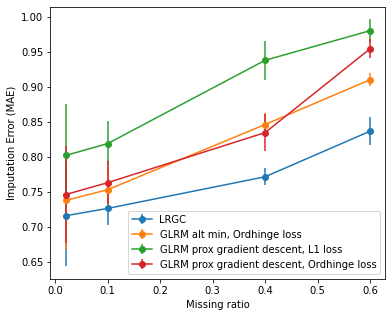

In [45]:
# Plot error vs missing ratio
# This graph may differ from the data collected in the csvs, because the pyglrm implementation includes the
# row of ones when counting rank LOL
plt.figure(figsize=(6, 5))
ratios = [0.02, 0.1, 0.4, 0.6]
lrgc_mean_errs = [0.7163194444444444, 0.7267361111111111, 0.7719444444444444, 0.8370486111111111]
lrgc_std_errs = [0.07245923071172253, 0.023958465759444176, 0.01212878793413163, 0.019675205668504978]

glrmabsprox_mean_errs = [0.8024305555555555, 0.819375, 0.9383680555555556, 0.9806828703703704]
glrmabsprox_std_errs = [0.07312869479400137, 0.03184887496572204, 0.027672153899646917, 0.01616196151545581]

glrmord_mean_errs = [0.7381944444444445, 0.7534722222222222, 0.8466319444444445, 0.9105555555555556]
glrmord_std_errs = [0.07089493938321301, 0.03189036867198446, 0.01577840548078034, 0.009517120899205454]

glrmordprox_mean_errs = [0.7465277777777778, 0.7635416666666667, 0.8350520833333334, 0.9547453703703703]
glrmordprox_std_errs = [0.0686910891200338, 0.030717523275686342, 0.026544362285883416, 0.013702143666799992]

plt.errorbar(ratios, lrgc_mean_errs, yerr=lrgc_std_errs,  label='LRGC', marker='o')
plt.errorbar(ratios, glrmord_mean_errs, yerr=glrmord_std_errs, label='GLRM alt min, Ordhinge loss', marker='o')
plt.errorbar(ratios, glrmabsprox_mean_errs, yerr=glrmabsprox_std_errs, label='GLRM prox gradient descent, L1 loss', marker='o')
plt.errorbar(ratios, glrmordprox_mean_errs, yerr=glrmordprox_std_errs, label='GLRM prox gradient descent, Ordhinge loss', marker='o')
plt.xlabel('Missing ratio')
plt.ylabel('Imputation Error (MAE)')
plt.legend()
#plt.show()
plt.savefig('imputation_exp_outputs/lrgcvsglrm_ord/Figures/methods_comparison_error.pdf')

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


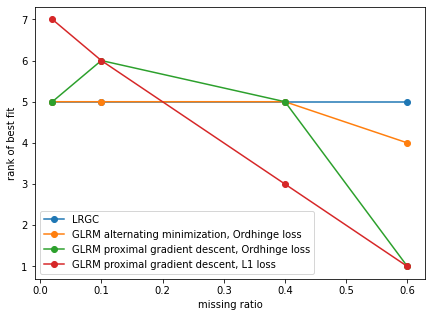

In [106]:
# Plot best rank vs missing ratio
# This graph may differ from the data collected in the csvs, because the pyglrm implementation includes the
# row of ones when counting rank LOL
plt.figure(figsize=(7, 5))
ratios = [0.02, 0.1, 0.4, 0.6]
lrgc_ranks = [5, 5, 5, 5]
glrmabsprox_ranks = [7, 6, 3, 1]
glrmord_ranks = [5, 5, 5, 4]
glrmordprox_ranks = [5, 6, 5, 1]

plt.plot(ratios, lrgc_ranks, marker='o', label='LRGC')
plt.plot(ratios, glrmord_ranks, marker='o', label='GLRM alternating minimization, Ordhinge loss')
plt.plot(ratios, glrmordprox_ranks, marker='o', label='GLRM proximal gradient descent, Ordhinge loss')
plt.plot(ratios, glrmabsprox_ranks, marker='o', label='GLRM proximal gradient descent, L1 loss')
plt.xlabel('missing ratio')
plt.ylabel('rank of best fit')
plt.legend()
plt.savefig('imputation_exp_outputs/lrgcvsglrm_ord/Figures/methods_comparison_rank.pdf')

# Random select noise

In [32]:
# Create continuous data
m, n, k = 120, 60, 5
noise = 'rndselect'
noise_lvl = 0.3
ratio = 0.2
iterations = 2

## LRGC

In [33]:
k_exp_list = [5]
model_type = 'lrgc'
loss = 'absolute'
exp_name = 'rndselect_ord/0.2ratio_lrgc_0.3noise'

## GLRM

In [80]:
k_exp_list = [5]
model_type = 'glrm'
loss = 'ordhinge'
exp_name = 'rndselect_ord/0.1ratio_glrm_0.3noise'

## Pyglrm

In [37]:
k_exp_list = [5]
model_type = 'pyglrm'
loss = 'ordhinge'
exp_name = 'rndselect_ord/0.2ratio_pyglrm_0.3noise'

## Pyglrm abs

In [35]:
k_exp_list = [5]
model_type = 'pyglrm'
loss = 'absolute'
exp_name = 'rndselect_ord/0.2ratio_pyglrm_abs_0.3noise'

In [38]:
%%capture
imputation_exp(A, ratio, k_exp_list, model_type, iterations, exp_name, loss=loss, mode='w')

# Check if normal GLRM does strange imputation

## GLRM

### 0.4 Missing

In [27]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.4
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=seed)
A_masked, mask_indices, _ = mask(A, ratio, seed=seed)

In [28]:
%%capture
k_model=5
mask_indices_split = [[tuple(index) for index in mask_indices]]
loss = [OrdinalLoss]
regX, regY = QuadraticReg(reg), QuadraticReg(reg)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
model = GLRM([A], loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
model.fit();
A_imp = model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


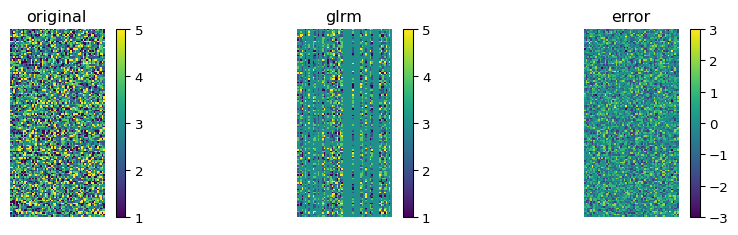

In [29]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

### 0.02 Missing

In [30]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.02
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=seed)
A_masked, mask_indices, _ = mask(A, ratio, seed=seed)

In [31]:
%%capture
k_model=5
mask_indices_split = [[tuple(index) for index in mask_indices]]
loss = [OrdinalLoss]
regX, regY = QuadraticReg(reg), QuadraticReg(reg)
converge = Convergence(TOL = 1e-3, max_iters = 1000, max_buffer=10)
model = GLRM([A], loss, regX, regY, k_model, mask_indices_split, converge=converge, obj_type=1)
model.fit();
A_imp = model.predict()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


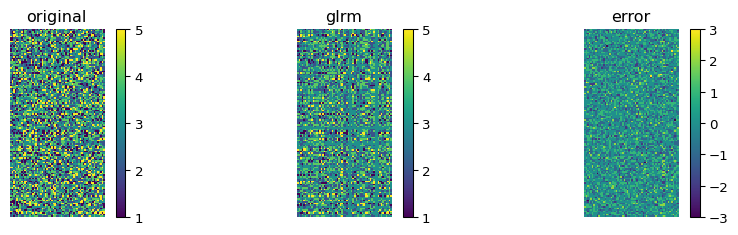

<Figure size 432x288 with 0 Axes>

In [32]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

## GLRM H2O

### 0.4 Missing

In [33]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.4
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=seed)
A_masked, mask_indices, _ = mask(A, ratio, seed=seed)

In [36]:
A_masked = pd.DataFrame(A_masked)
for index in mask_indices:
    A_masked.loc[index[0], index[1]] = 'missing'
train = h2o.H2OFrame(A_masked, na_strings=['missing'], column_types = ['enum']*A.shape[1])
glrm_model = H2OGeneralizedLowRankEstimator(k=k_model,
            loss='absolute',
            gamma_x=reg,
            gamma_y=reg,
            max_iterations=700,
            recover_svd=True,
            init="SVD")
glrm_model.train(training_frame=train)
A_imp = glrm_model.predict(train)
A_imp = A_imp.as_data_frame().to_numpy()

/Users/ongrayyi/opt/anaconda3/envs/iibproject/lib/python3.8/http/cookiejar.py:1220: ResourceWarning: unclosed file <_io.FileIO name='/var/folders/1r/xbbm4brd1t5fjqmzh34nsv9w0000gn/T/tmpkv6jx8ja.csv' mode='rb' closefd=True>
  keys = sorted(adict.keys())


Parse progress: |█████████████████████████████████████████████████████████| 100%
glrm Model Build progress: |██████████████████████████████████████████████| 100%
glrm prediction progress: |███████████████████████████████████████████████| 100%


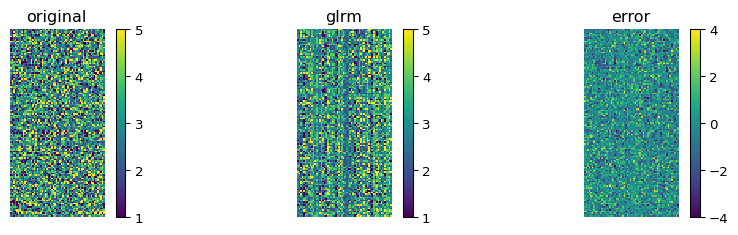

In [37]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

## pyGLRM

In [17]:
m=120
n=60
k=5
noise='gaussian'
noise_lvl=0.1
ratio=0.4
reg=0
seed=0
A = generate_data(m, n, k, noise, noise_lvl, ord_num=5, seed=seed)
A_masked, mask_indices, _ = mask(A, ratio, seed=seed)

In [18]:
glrm_loss = pyglrm.HingeLoss()
regX, regY = pyglrm.ZeroReg(), pyglrm.ZeroReg()
model = pyglrm.glrm(glrm_loss, regX, regY, n_components=5, offset=True, scale=True)
A_imp = model.fit_impute(A_masked)

/Users/ongrayyi/.local/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


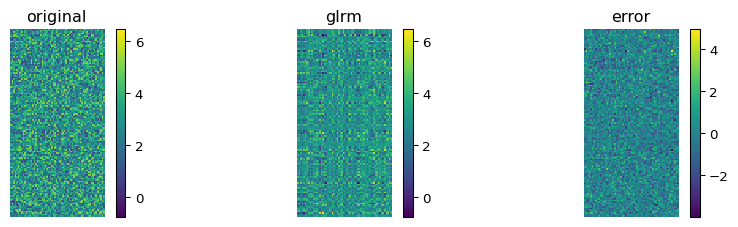

In [19]:
pplot([A, A_imp, A - A_imp], ["original", "glrm", "error"])

In [20]:
A_imp

array([[2.53540962, 1.10942901, 3.99564196, ..., 2.4991201 , 3.87274445,
        3.0671542 ],
       [2.41043652, 1.94884701, 3.11270058, ..., 2.75978964, 3.50741027,
        2.68976675],
       [2.42941867, 0.81193052, 3.70559295, ..., 2.73652178, 3.79125822,
        3.05013644],
       ...,
       [0.98515214, 0.96693782, 1.5496306 , ..., 4.85949329, 0.80407287,
        4.03249014],
       [1.81138093, 2.05087517, 2.39871445, ..., 2.58166485, 3.34058565,
        2.00665145],
       [2.30837882, 3.27839261, 1.96815225, ..., 3.41201617, 2.63051225,
        2.59974752]])